# Variational Quantum Regression
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
## Introduction

Here we create a protocol for linear regression which can exploit the properties of a quantum computer. For this problem, we assume that we have two data sets, x and y, where x is the independent data and y is the dependent data. There are N data points in each data set. We first want to fit this data to the following equation:

$$y = ax + b$$

and then we will include higher powers of x. First, we will theoretically explore this proposed algorithms, and then we will tweak the code slightly so that it can be run on a real quantum computer.

## Variational Quantum Computing

Variational quantum computing exploits the advantages of both classical computing and quantum computing. In a very general sense, we propose an initial solution to a problem, in our case it is an initial guess for a and b. We then prepare our qubits (the quantum equivalent of bits on a normal computer) and test how good the solution is, using the quantum computer. Testing the solution equates to minimising a cost function. We feed the result of this cost function back to the classical computer, and use some classical optimisers to improve on our initial guesses for a and b. We repeat this process until the solution is good enough within some tolerance. 
![title](Resources/vlinreg_circuit.png)

## Translate to Quantum Domain

We now need to explore how we will translate the data sets, x and y, onto a quantum computer. Let us think of x and y as length N vectors. The easiest way to encode these data sets onto a quantum computer is by initialising qubits in the states $\ket{x}$ and $\ket{y}$, where 

$$\ket{x} = \frac{1}{C_x}\vec{x}$$ and $C_x$ is a normalisation factor. Note that all of our starting states must be normalised.

Due to the definition of the tensor product and the fact that the general statevector of a single qubit is a vector of length 2, $n$ qubits can encode length $2^n$ vectors. 

### Cost Function

Thus, we propose a trial solution for the two unknown parameters, a and b, as

$$\ket{\Phi} = a\frac{C_x}{C_y}\ket{x} + \frac{b}{C_y}\ket{1}$$ 

Our proposed cost function, which we wish to minimise is equal to

$$C_P = \left(1 - \braket{y}{\Phi}\right)^2$$

This computes the normalised fidelity (similarity) of $\ket{y}$ and $\ket{\Phi}$. We see that if $\ket{y}$ and $\ket{\Phi}$ are equal, our cost function will equal 0, otherwise it will be greater than 0. Thus, we need to compute this cost function with our quantum hardware, coupled with classical minimising algorithms. 

Breaking down the cost function further, we see that it boils down to computing the following inner products, assuming real states:

$$\braket{y}{\Phi} = a\frac{C_2}{C_1} \braket{y}{x} + \frac{b}{C_1}\braket{y}{1}$$

### Computing Inner Products on a Quantum Computer

It is clear we now need a quantum algorithm for computing inner products. Let us go through the theory here, which will be translated to quantum hardware in a couple of sections. 

Firstly, assume we have a state:

$$\ket{\phi} = \frac{1}{\sqrt{2}}(\ket{0}\ket{x} + \ket{1}\ket{y})$$

where we want to find the inner product, $\braket{x}{y}$. Applying a Hadamard gate on the first qubit, we find:

\begin{equation}
    \ket{\tilde{\phi}} = \frac{1}{2}(\ket{0}(\ket{x}+\ket{y}) + \ket{1}(\ket{x}-\ket{y}))
\end{equation}

This means that the probability to measure the first qubit as $\ket{0}$ in the computational basis equals:

\begin{equation}
    P(0) = \frac{1}{2}(1+Re[\braket{x}{y}])
\end{equation}

This follows because:

\begin{align}
    P(0) &= \left|\bra{0}\otimes\mathbb{1}\ket{\tilde{\phi}}\right|^2 \\
    &= \frac{1}{4}\left|\ket{x}+\ket{y}\right|^2 \\
    &= \frac{1}{4}(\braket{x}{x}+\braket{x}{y}+\braket{y}{x}+\braket{y}{y}) \\
    &= \frac{1}{4}(2 + 2 \times Re[\braket{x}{y}]) \\
    &= \frac{1}{2}(1+Re[\braket{x}{y}])
\end{align}

It follows from a similar logic that if we apply a phase rotation on our initial state:
\begin{equation}
    \ket{\phi} = \frac{1}{\sqrt{2}}(\ket{0}\ket{x} -i \ket{1}\ket{y})
\end{equation}

then the probability of the same measurement:
\begin{equation}
    P(0) = \frac{1}{2}(1+Im[\braket{x}{y}])
\end{equation}

We can then combine both probabilities to find the true $\braket{x}{y}$. For this work, we assume that our states are fully real, and so just need the first measurement. 

## Translating to Quantum Hardware - Theoretical Approach

Firstly, this is coded using qiskit and it should be noted that qiskit orders its qubits with the last qubit corresponding to the left of the tensor product. For this run through, we are computing the inner product of length-8 vectors. Thus, we require 4 qubits to encode the state:

\begin{align}
    \ket{\phi} &= \frac{1}{\sqrt{2}}(\ket{0}\ket{x} + \ket{1}\ket{y}) \\ &= \frac{1}{\sqrt{2}}\left(\begin{bmatrix}1\\0\end{bmatrix}\otimes\begin{bmatrix}x_1\\x_2\\\vdots\\x_n \end{bmatrix} +\begin{bmatrix}0\\1\end{bmatrix}\otimes\begin{bmatrix}y_1\\y_2\\\vdots\\y_n \end{bmatrix} \right) \\
    &= \frac{1}{\sqrt{2}}\left(\begin{bmatrix}x_1\\x_2\\\vdots\\x_n \\y_1\\y_2\\\vdots\\y_n \end{bmatrix} \right)
\end{align}

Finally, in order to measure the probability of measuring the bottom (leftmost) qubit as $\ket{0}$ in the computational basis, we can find the exact theoretical value by finding the resultant statevector and summing up the amplitude squared of the first $2^{n-1}$ entries (i.e. half of them). On a real quantum computer, we would just have to perform the actual measurement many times over, and compute the probability that way. We will show the theoretical approach in practice first. 

In [16]:
# importing necessary packages
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Now, let's draw the required diagram for theoretically computing the inner product of any two states. Note that the only difference between this circuit diagram and the real, practical diagram for actually running on a quantum computer is that we do not measure the left-most qubit in the computational basis. Again, note that the left-most qubit corresponds to the bottom qubit.

In [91]:
import pandas as pd
data = pd.read_csv("outputBOD.csv")
data = data.drop("Unnamed: 0", axis = 1)
data = data.iloc[0:128,]
data['BOD_Y_binary'] = np.where(data['BOD_Y'] >= data['BOD_Y'].median(), 1, 0)
data.head()
print(data['BOD_Y'],data['BOD_Y_binary'])

0      5.2
1      6.0
2      6.1
3      5.4
4      5.9
      ... 
123    5.0
124    5.9
125    5.9
126    5.9
127    5.9
Name: BOD_Y, Length: 128, dtype: float64 0      1
1      1
2      1
3      1
4      1
      ..
123    1
124    1
125    1
126    1
127    1
Name: BOD_Y_binary, Length: 128, dtype: int32


In [94]:
x = data['BOD_Y']
y = data['BOD_Y_binary']
#x = data['NH3_Y']#np.arange(0,8,1)
#y = data['NH3_Y_binary']#x

#x = data['TN_Y']
#y = data['TN_Y_binary']
# 
N = len(x)
print(N)
print(x,y)
nqubits = math.ceil(np.log2(N))
print(nqubits)

xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
print(xnorm,ynorm)

vec = np.concatenate((x,y))/np.sqrt(2)
print(vec)

128
0      5.2
1      6.0
2      6.1
3      5.4
4      5.9
      ... 
123    5.0
124    5.9
125    5.9
126    5.9
127    5.9
Name: BOD_Y, Length: 128, dtype: float64 0      1
1      1
2      1
3      1
4      1
      ..
123    1
124    1
125    1
126    1
127    1
Name: BOD_Y_binary, Length: 128, dtype: int32
7
61.22556655515733 11.313708498984761
[3.67695526 4.24264069 4.31335137 3.81837662 4.17193001 4.45477272
 3.67695526 4.17193001 4.24264069 4.24264069 3.67695526 3.81837662
 4.38406204 3.95979797 5.65685425 4.03050865 4.03050865 5.86898628
 4.45477272 4.17193001 8.48528137 7.77817459 5.79827561 4.5254834
 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391
 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391
 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391
 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391
 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391 3.53553391
 3.53553391 3.53553391 3.53553391 3.53553391 3.5

In [95]:
# x = np.arange(0,8,1)
# y = x
x = data['BOD_Y']
y = data['BOD_Y_binary']

#x = data['NH3_Y']
#y = data['NH3_Y_binary']
#x = data['TN_Y']
#y = data['TN_Y_binary']

N = len(x)
print(N)
nqubits = math.ceil(np.log2(N))
print(nqubits)
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

circ = QuantumCircuit(nqubits+1)
vec = np.concatenate((x,y))/np.sqrt(2)

circ.initialize(vec, range(nqubits+1))
circ.h(nqubits)

circ.draw()

128
7


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Now let's build a function around this circuit, so that we can theoretically compute the inner product between any two vectors. 

In [96]:
#Calculates the inner product between two vectors

def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend, backend_options = {"zero_threshold": 1e-20})

    result = job.result()
    o = np.real(result.get_statevector(circ))

    m_sum = 0
    for l in range(N):
        m_sum += o[l]**2
        
    return 2*m_sum-1

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

print("x: ", x)
print()
print("y: ", y)
print()
print("The inner product of x and y equals: ", inner_prod(x,y))

x:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

y:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

The inner product of x and y equals:  1.0


<ipython-input-96-acf471cf0c20>:15: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = execute(circ, backend, backend_options = {"zero_threshold": 1e-20})


Now, let's build a function to compute the cost function associated with any choice of a and b. We have set up x and y such that the correct parameters are (a,b) = (1,0). 

In [97]:
#Implements the entire cost function on the quantum circuit

def calculate_cost_function(parameters):

    a, b = parameters
    
    #phiphi = (xnorm/ynorm*a)**2.0 + 2.0*a*b*xnorm*np.sqrt(N)/ynorm**2*inner_prod(x,ones) + b**2*N/ynorm**2
    
    yphi = a*xnorm/ynorm*inner_prod(y,x) + b*np.sqrt(N)/ynorm*inner_prod(y,ones)
    
    #print("phiphi: ", phiphi)
    #print("yphi: ", yphi)

    #print(abs(1-float(yphi**2/phiphi)))
    #return (1-float(yphi**2/phiphi))**2
    
    return (1-yphi)**2

ones = np.ones(N)/np.sqrt(N)
a = 1.0
b = 1.0
print("Cost function for a =", a, "and b =", b, "equals:", calculate_cost_function([a,b]))

Cost function for a = 1.0 and b = 1.0 equals: 0.03999999999999998


<ipython-input-96-acf471cf0c20>:15: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = execute(circ, backend, backend_options = {"zero_threshold": 1e-20})


Now putting everything together and using a classical optimiser from the scipy library, we get the full code.

<ipython-input-96-acf471cf0c20>:15: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = execute(circ, backend, backend_options = {"zero_threshold": 1e-20})


COBYLA:       fun: 6.027934044562022e-11
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 54
  status: 1
 success: True
       x: array([0.09930537, 0.47126874])
BFGS:        fun: 1.4169199511622073e-16
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([5.49160855e-07, 3.87080505e-08])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([0.10774786, 0.42632682])
Nelder-Mead:   final_simplex: (array([[0.08167289, 0.56515567],
       [0.08167278, 0.56515626],
       [0.08167284, 0.56515595]]), array([0., 0., 0.]))
           fun: 0.0
       message: 'Optimization terminated successfully.'
          nfev: 176
           nit: 95
        status: 0
       success: True
             x: array([0.08167289, 0.56515567])
CG:       fun: 1.4169199511622073e-16
     jac: array([5.49160855e-07, 3.87080505e-08])
 message: 'Optimization terminated successfully.'
    nfev: 9
     nit: 1


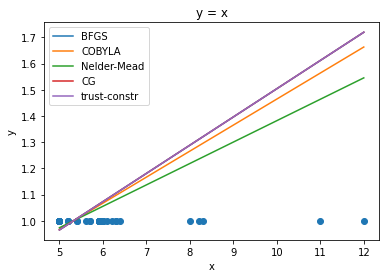

In [98]:
#first set up the data sets x and y

# x = np.arange(0,8,1)
# y = x #+ [random.uniform(-1,1) for p in range(8)]
x = data['BOD_Y']
y = data['BOD_Y_binary']

#x = data['NH3_Y']
#y = data['NH3_Y_binary']

#x = data['TN_Y']
#y = data['TN_Y_binary']
N = len(x)

nqubits = math.ceil(np.log2(N))

ones = np.ones(N)/np.sqrt(N)    #need a normalised ones' state for including the parameter b

xnorm = np.linalg.norm(x)       #normalise data sets
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

#x0 = [random.uniform(0,2) for p in range(2)]    #random initial guess for a and b
x0 = [0.5,0.5]

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

out_a1 = out1['x'][0]
out_b1 = out1['x'][1]

print("COBYLA: ", out1)

out_a = out['x'][0]
out_b = out['x'][1]

print("BFGS: ", out)

out_a2 = out2['x'][0]
out_b2 = out2['x'][1]

print("Nelder-Mead: ", out2)

out_a3 = out3['x'][0]
out_b3 = out3['x'][1]

print("CG: ", out3)

out_a4 = out4['x'][0]
out_b4 = out4['x'][1]

print("trust-constr: ", out4)

plt.scatter(x*xnorm,y*ynorm)
xfit = np.linspace(min(x)*xnorm, max(x)*xnorm, 100)
#plt.plot(xfit, preout['x'][0]*xfit+preout['x'][1], label='Basinhopping')
plt.plot(xfit, out_a*xfit+out_b, label='BFGS')
plt.plot(xfit, out_a1*xfit+out_b1, label='COBYLA')
plt.plot(xfit, out_a2*xfit+out_b2, label='Nelder-Mead')
plt.plot(xfit, out_a3*xfit+out_b3, label='CG')
plt.plot(xfit, out_a4*xfit+out_b4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Translating to Quantum Hardware - Practical Approach

In order to modify the above slightly so that it can be run on a real quantum computer, we simply have to modify the inner_prod function. Instead of theoretically extracting the probabilility of measuring a 0 on the leftmost qubit in the computational basis, we must actually measure this qubit a number of times and calculate the probability from these samples. Our new circuit can be created as follows, which is identical to the theoretical circuit, but we just add a measurement, and hence need a classical bit.

In [99]:
circ = QuantumCircuit(nqubits+1,1)
vec = np.concatenate((x,y))/np.sqrt(2)

circ.initialize(vec, range(nqubits+1))
circ.h  (nqubits)
circ.initialize(vec, range(nqubits+1))
circ.h  (nqubits)


circ.measure(nqubits,0)

circ.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
c: 1/»
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Now, we can build a new inner_prod function around this circuit, using a different simulator from qiskit.

In [100]:
#Calculates the inner product between two vectors
def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1,1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)
    circ.measure(nqubits,0)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots=10000)

    result = job.result()
    outputstate = result.get_counts(circ)

    if ('0' in outputstate.keys()):
        m_sum = float(outputstate["0"])/10000
    else:
        m_sum = 0
    
    return 2*m_sum-1

# x = np.arange(0,8,1)
# y = x

x = data['BOD_Y']
y = data['BOD_Y_binary']
#x = data['NH3_Y']
#y = data['NH3_Y_binary']
#x = data['TN_Y']
#y = data['TN_Y_binary']

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

print("x: ", x)
print()
print("y: ", y)
print()
print("The inner product of x and y equals: ", inner_prod(x,y))

x:  0      0.084932
1      0.097998
2      0.099632
3      0.088198
4      0.096365
         ...   
123    0.081665
124    0.096365
125    0.096365
126    0.096365
127    0.096365
Name: BOD_Y, Length: 128, dtype: float64

y:  0      0.088388
1      0.088388
2      0.088388
3      0.088388
4      0.088388
         ...   
123    0.088388
124    0.088388
125    0.088388
126    0.088388
127    0.088388
Name: BOD_Y_binary, Length: 128, dtype: float64

The inner product of x and y equals:  0.9832000000000001


Our cost function calculation is the same as before, but we now just use this new method for computing the inner product, so the full code can be run as follows.

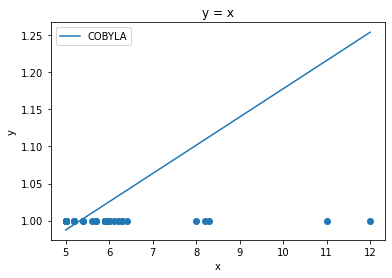

In [102]:
#first set up the data sets x and y

# x = np.arange(0,8,1)
# y = x #+ [random.uniform(-1,1) for p in range(8)]
x = data['BOD_Y']
y = data['BOD_Y_binary']

#x = data['NH3_Y']
#y = data['NH3_Y_binary']

#x = data['TN_Y']
#y = data['TN_Y_binary']
N = len(x)
nqubits = math.ceil(np.log2(N))

ones = np.ones(N)/np.sqrt(N)    #need a normalised ones' state for including the parameter b

xnorm = np.linalg.norm(x)       #normalise data sets
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

#x0 = [random.uniform(0,2) for p in range(2)]    #random initial guess for a and b
x0 = [1,1]

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

out_a1 = out1['x'][0]
out_b1 = out1['x'][1]

out_a = out['x'][0]
out_b = out['x'][1]

out_a2 = out2['x'][0]
out_b2 = out2['x'][1]

out_a3 = out3['x'][0]
out_b3 = out3['x'][1]

out_a4 = out4['x'][0]
out_b4 = out4['x'][1]

plt.scatter(x*xnorm,y*ynorm)
xfit = np.linspace(min(x)*xnorm, max(x)*xnorm, 100)
# plt.plot(xfit, out_a*xfit+out_b, label='BFGS')
plt.plot(xfit, out_a1*xfit+out_b1, label='COBYLA')
# plt.plot(xfit, out_a2*xfit+out_b2, label='Nelder-Mead')
# plt.plot(xfit, out_a3*xfit+out_b3, label='CG')
# plt.plot(xfit, out_a4*xfit+out_b4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Extending to Higher Order Fits

We can also extend to fitting to quadratic, cubic, and higher order polynomials. The code remains relatively unchanged, but will update the cost function slightly. We can of course use either the theoretical or practical method for computing the inner products in the following cost function. 

In [11]:
#new cost function calculation, allowing for higher order polynomials
#note that we are now normalising each power of x in this function
def calculate_cost_function_n(parameters):

    yphi = parameters[0]*np.sqrt(N)/ynorm*inner_prod(y,ones)

    for i in range(1,len(parameters)):

        xpow = x**i
        xnormpow = np.linalg.norm(xpow)
        xpow = xpow/xnormpow
        
        yphi += parameters[i]*xnormpow/ynorm*inner_prod(y,xpow)
    
    #print((1-yphi)**2)
    return (1-yphi)**2

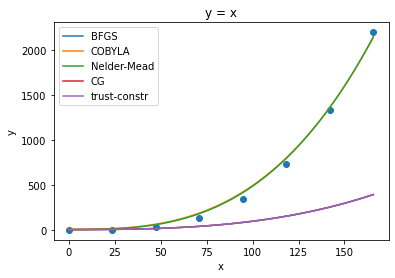

In [12]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = (2*x-1)**3 + [random.uniform(-1,1) for p in range(8)]
N = len(x)
nqubits = math.ceil(np.log2(N))

ones = np.ones(N)/np.sqrt(N)    #need a normalised ones' state for including the parameter b
       
ynorm = np.linalg.norm(y)       #normalise y data set
y = y/ynorm

order = 3

x0 = [random.uniform(0,2) for p in range(order+1)]    #random initial guess for a and b
#x0 = [1,1]

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function_n, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function_n, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function_n, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function_n, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function_n, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

class_fit = np.polyfit(x,y*ynorm,order)
class_fit = class_fit[::-1]

xfit = np.linspace(min(x), max(x), 100)

def return_fits(xfit):
    c_fit = np.zeros(100)
    q_fit = np.zeros(100)
    q_fit1 = np.zeros(100)
    q_fit2 = np.zeros(100)
    q_fit3 = np.zeros(100)
    q_fit4 = np.zeros(100)
    for i in range(order+1):
        c_fit += xfit**i*class_fit[i]
        q_fit += xfit**i*out['x'][i]
        q_fit1 += xfit**i*out1['x'][i]
        q_fit2 += xfit**i*out2['x'][i]
        q_fit3 += xfit**i*out3['x'][i]
        q_fit4 += xfit**i*out4['x'][i]
        

    return c_fit, q_fit, q_fit1, q_fit2, q_fit3, q_fit4

c_fit, q_fit, q_fit1, q_fit2, q_fit3, q_fit4 = return_fits(xfit)

plt.scatter(x*xnorm,y*ynorm)
xfit = np.linspace(min(x)*xnorm, max(x)*xnorm, 100)
plt.plot(xfit, q_fit, label='BFGS')
plt.plot(xfit, q_fit1, label='COBYLA')
plt.plot(xfit, q_fit2, label='Nelder-Mead')
plt.plot(xfit, q_fit3, label='CG')
plt.plot(xfit, q_fit4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Acknowledgements

I would like to thank Dr. Lee O'Riordan for his supervision and guidance on this work. The work was mainly inspired by work presented in the research paper "Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems", written by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles, which is available at this [link](https://arxiv.org/abs/1909.05820). I would also like to thank the Irish Centre for High End Computing for allowing me to access the national HPC infrastructure, Kay.

In [77]:
import pandas as pd
data = pd.read_csv("outputNH3.csv")
data = data.drop("Unnamed: 0", axis = 1)
data = data.iloc[0:16,]
data['NH3_Y_binary'] = np.where(data['NH3_Y'] >= data['NH3_Y'].median(), 1, 0)
data.head()
print(data['NH3_Y'],data['NH3_Y_binary'])

0     0.98
1     0.59
2     0.57
3     0.78
4     0.72
5     1.30
6     0.65
7     0.55
8     0.82
9     0.70
10    0.95
11    1.90
12    0.90
13    0.57
14    0.77
15    0.69
Name: NH3_Y, dtype: float64 0     1
1     0
2     0
3     1
4     0
5     1
6     0
7     0
8     1
9     0
10    1
11    1
12    1
13    0
14    1
15    0
Name: NH3_Y_binary, dtype: int32


In [46]:
import pandas as pd
data = pd.read_csv("Test_TN.csv")
data = data.drop("Unnamed: 0", axis = 1)
data = data.iloc[0:16,]
data['TN_Y_binary'] = np.where(data['TN_Y'] >= data['TN_Y'].median(), 1, 0)
data.head()
print(data['TN_Y'],data['TN_Y_binary'])

0     12.0
1     12.0
2      9.7
3     12.0
4     13.0
5     10.0
6      9.4
7      9.6
8      9.0
9      9.3
10    10.0
11     9.0
12     8.1
13     9.6
14     9.1
15     9.5
Name: TN_Y, dtype: float64 0     1
1     1
2     1
3     1
4     1
5     1
6     0
7     1
8     0
9     0
10    1
11    0
12    0
13    1
14    0
15    0
Name: TN_Y_binary, dtype: int32
